In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = './Results_Corruption'
model_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
model_names = [os.path.splitext(f)[0] for f in model_files]

corruption_list = sorted(list({
    row['corruption']
    for file in model_files
    for _, row in pd.read_csv(os.path.join(folder_path, file)).iterrows()
}))

corruption_to_idx = {name: idx for idx, name in enumerate(corruption_list)}

n_corruptions = len(corruption_list)
n_severities = 5
n_models = len(model_files)

# Initialisation du tableau (n_models, n_corruptions, n_severities)
all_data = np.zeros((n_models, n_corruptions, n_severities))

for i, file in enumerate(model_files):
    df = pd.read_csv(os.path.join(folder_path, file))
    for _, row in df.iterrows():
        c_idx = corruption_to_idx[row['corruption']]
        s_idx = int(row['severity']) - 1
        all_data[i, c_idx, s_idx] = row['f1_macro']


In [2]:
print("Ordre des modèles (model_names) :")
for i, name in enumerate(model_names):
    print(f"{i}: {name}")

Ordre des modèles (model_names) :
0: DenseNet_AdaGrad
1: DenseNet_Adam
2: DenseNet_SGD
3: ResNet_AdaGrad
4: ResNet_Adam
5: ResNet_SGD
6: VGGLike_AdaGrad
7: VGGLike_Adam
8: VGG_SGD


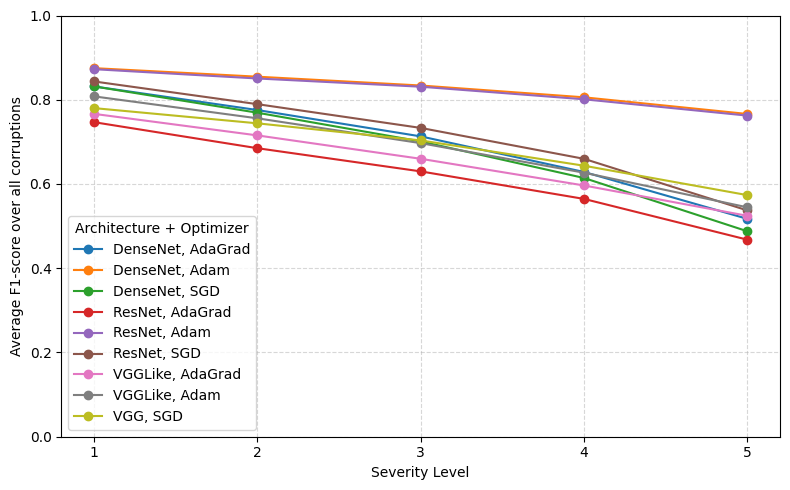

In [3]:
mean_f1_per_severity = all_data.mean(axis=1)  # moyenne sur l'axe des corruptions

# Tracé
plt.figure(figsize=(8, 5))
severities = np.arange(1, n_severities + 1)

display_names = [name.replace('_', ', ') for name in model_names]

for i, model_name in enumerate(display_names):
    plt.plot(severities, mean_f1_per_severity[i], marker='o', label=model_name)

plt.xlabel("Severity Level")
plt.ylabel("Average F1-score over all corruptions")
plt.xticks(severities)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Architecture + Optimizer")
plt.tight_layout()
plt.show()

[0.69321079 0.82711582 0.68080236 0.61881944 0.82348619 0.7126312
 0.65253411 0.68648444 0.6889254 ]


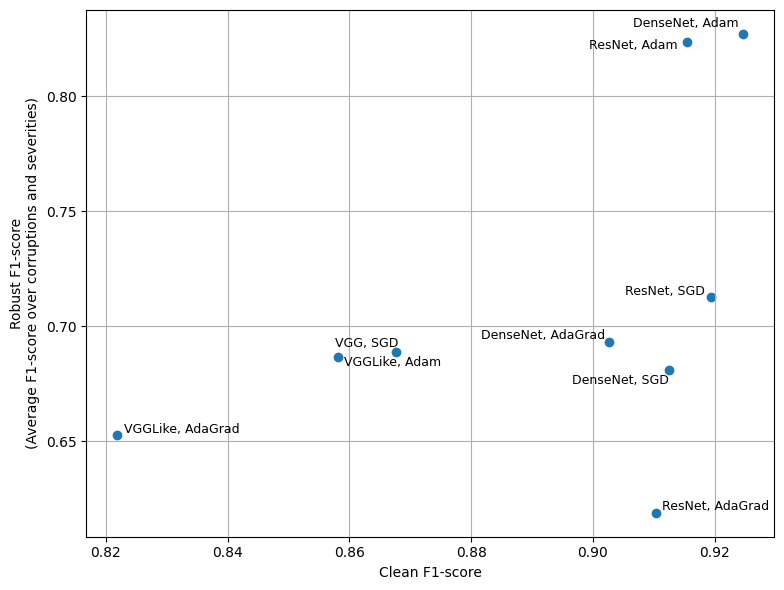

In [4]:
"""
Précision propre vs robustesse moyenne
    => visualise si certains modèles sacrifient la précision propre pour la robustesse, ou l’inverse

Axe X : Précision en conditions propres
Axe Y : Moyenne des performances corrompues
"""

"""
0: DenseNet_AdaGrad 0.9026944891
1: DenseNet_Adam 0.9246578628644885
2: DenseNet_SGD 0.9125940113141272
3: ResNet_AdaGrad 0.910335397
4: ResNet_Adam 0.9154097303205765
5: ResNet_SGD 0.9193440341235497
6: VGGLike_AdaGrad 0.8219071213
7: VGGLike_Adam 0.8581507263642598
8: VGG_SGD 0.8676458931227247
"""

clean_perfs = np.array([0.9026944891, 0.9246578628644885, 0.9125940113141272, 0.910335397, 0.9154097303205765, 0.9193440341235497, 0.8219071213, 0.8581507263642598, 0.8676458931227247])
robust_perfs = all_data.mean(axis=(1, 2))  # performance moyenne en condition corrompue

display_names = [name.replace('_', ', ') for name in model_names]


print(robust_perfs)

plt.figure(figsize=(8, 6))
plt.scatter(clean_perfs, robust_perfs)

for i, name in enumerate(display_names):
    # Décalage par défaut
    dx, dy = 0.001, 0.001
    
    # Cas particuliers pour éviter chevauchement
    if i == 7:
        dy = -0.004
    elif i == 8:
        dy = 0.002
        dx = -0.01
    elif i == 1:
        dx = -0.018
        dy = 0.0029
    elif i == 4:
        dx = -0.016
        dy = -0.003
    elif i == 2:
        dx = -0.016
        dy = -0.006
    elif i == 5:
        dx = -0.014
    elif i == 0:
        dx = -0.021

    plt.text(clean_perfs[i] + dx, robust_perfs[i] + dy, name, fontsize=9)



plt.xlabel('Clean F1-score')
plt.ylabel('Robust F1-score\n(Average F1-score over corruptions and severities)')
plt.grid(True)
plt.tight_layout()
plt.show()

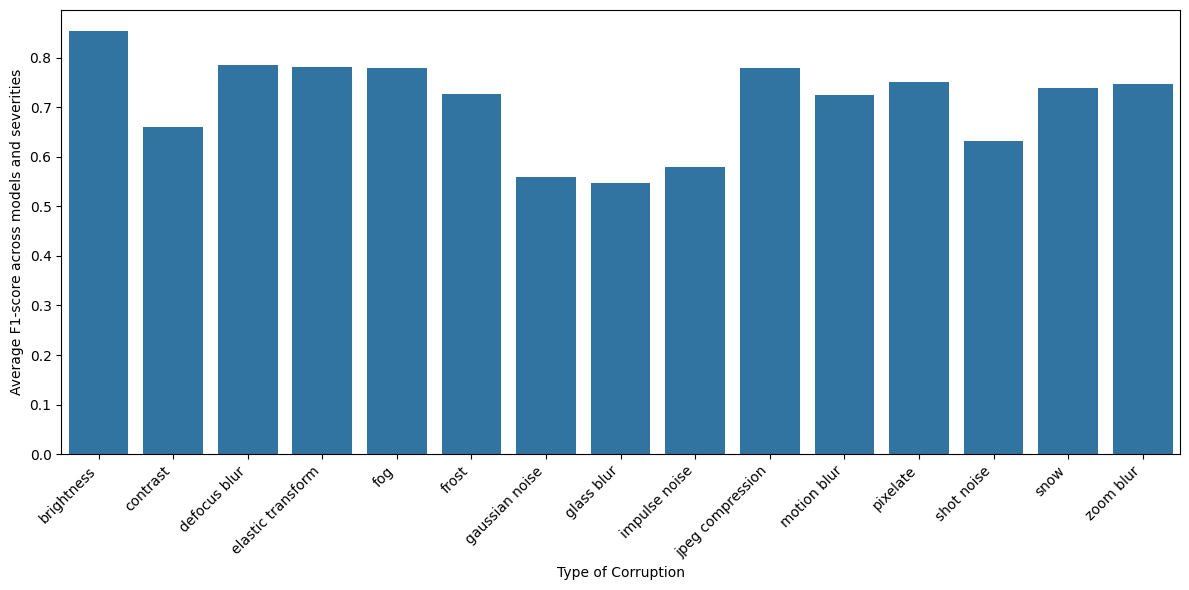

In [5]:
"""
Performance moyenne par corruption pour identifier les corruptions les plus dures en moyenne.

Axe X : Corruptions
Axe Y : Moyenne des scores sur tous les modèles et sévérités
"""
# Moyenne sur modèles et sévérités : shape (15,)
corruption_means = all_data.mean(axis=(0, 2))  

display_corruption = [cor.replace('_', ' ') for cor in corruption_list]

plt.figure(figsize=(12, 6))
sns.barplot(x=display_corruption, y=corruption_means)
plt.ylabel('Average F1-score across models and severities')
plt.xlabel('Type of Corruption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

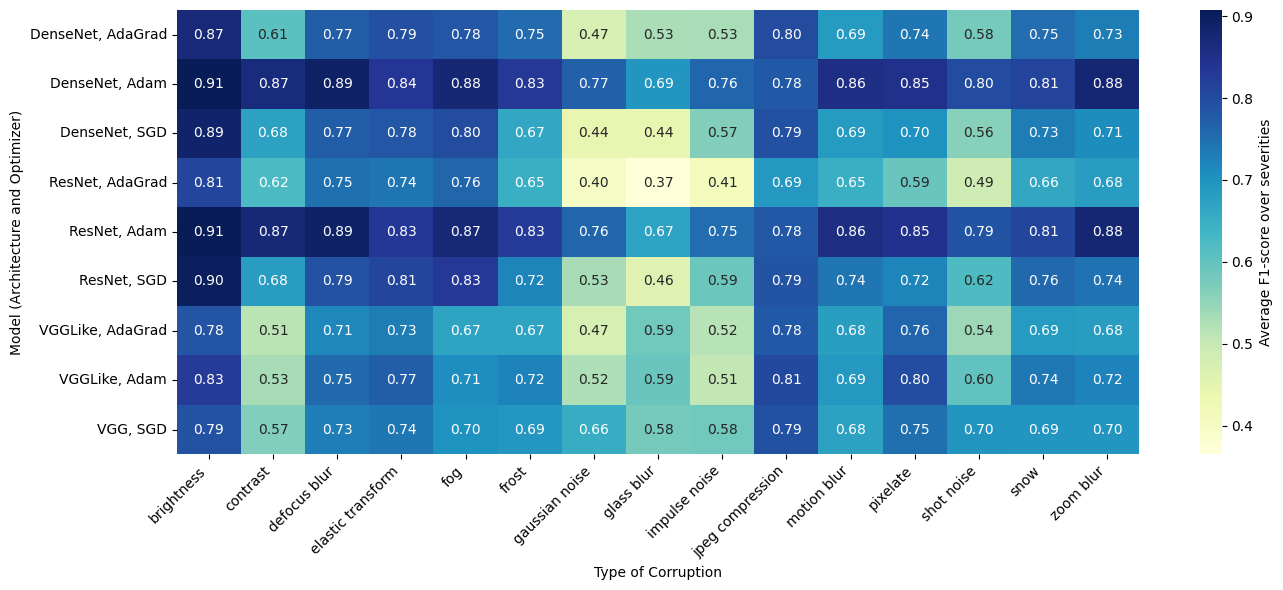

In [6]:
avg_over_severity = all_data.mean(axis=2)

display_names = [name.replace('_', ', ') for name in model_names]
display_corruption = [cor.replace('_', ' ') for cor in corruption_list]

df_heatmap = pd.DataFrame(
    avg_over_severity,
    index=display_names,
    columns=display_corruption
)

plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average F1-score over severities'})
plt.xlabel("Type of Corruption")
plt.ylabel("Model (Architecture and Optimizer)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

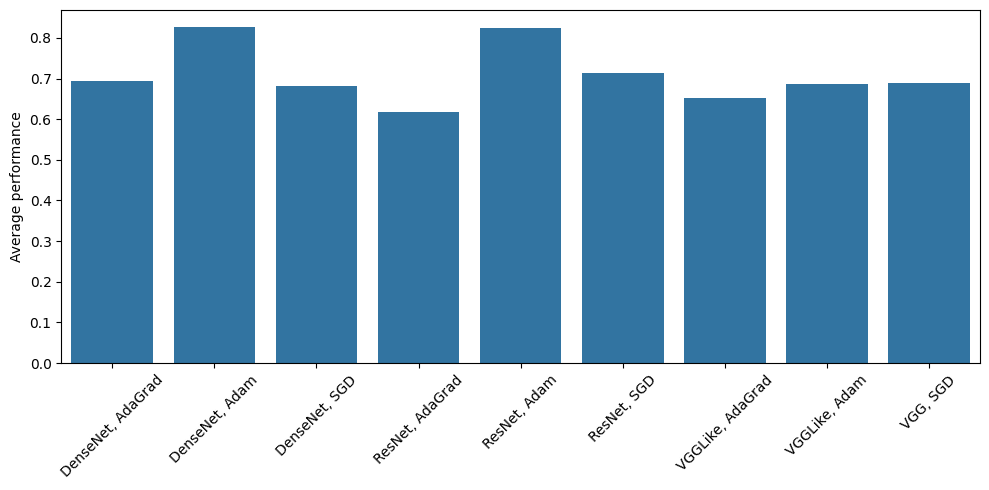

In [16]:
"""
Performances globales par modèle pour comparer la robustesse globale des modèles
    => permet de voir quel modèle est globalement le plus robuste

Axe X : Les 9 modèles
Axe Y : Moyenne des performances sur toutes les corruptions et sévérités
"""

model_means = all_data.mean(axis=(1, 2))  # mean over corruptions and severities

display_names = [name.replace('_', ', ') for name in model_names]  # ou tout autre transformation

plt.figure(figsize=(10, 5))
sns.barplot(x=display_names, y=model_means)
plt.ylabel('Average F1-score across corruptions and severities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that Adam is more robust than others through all. 

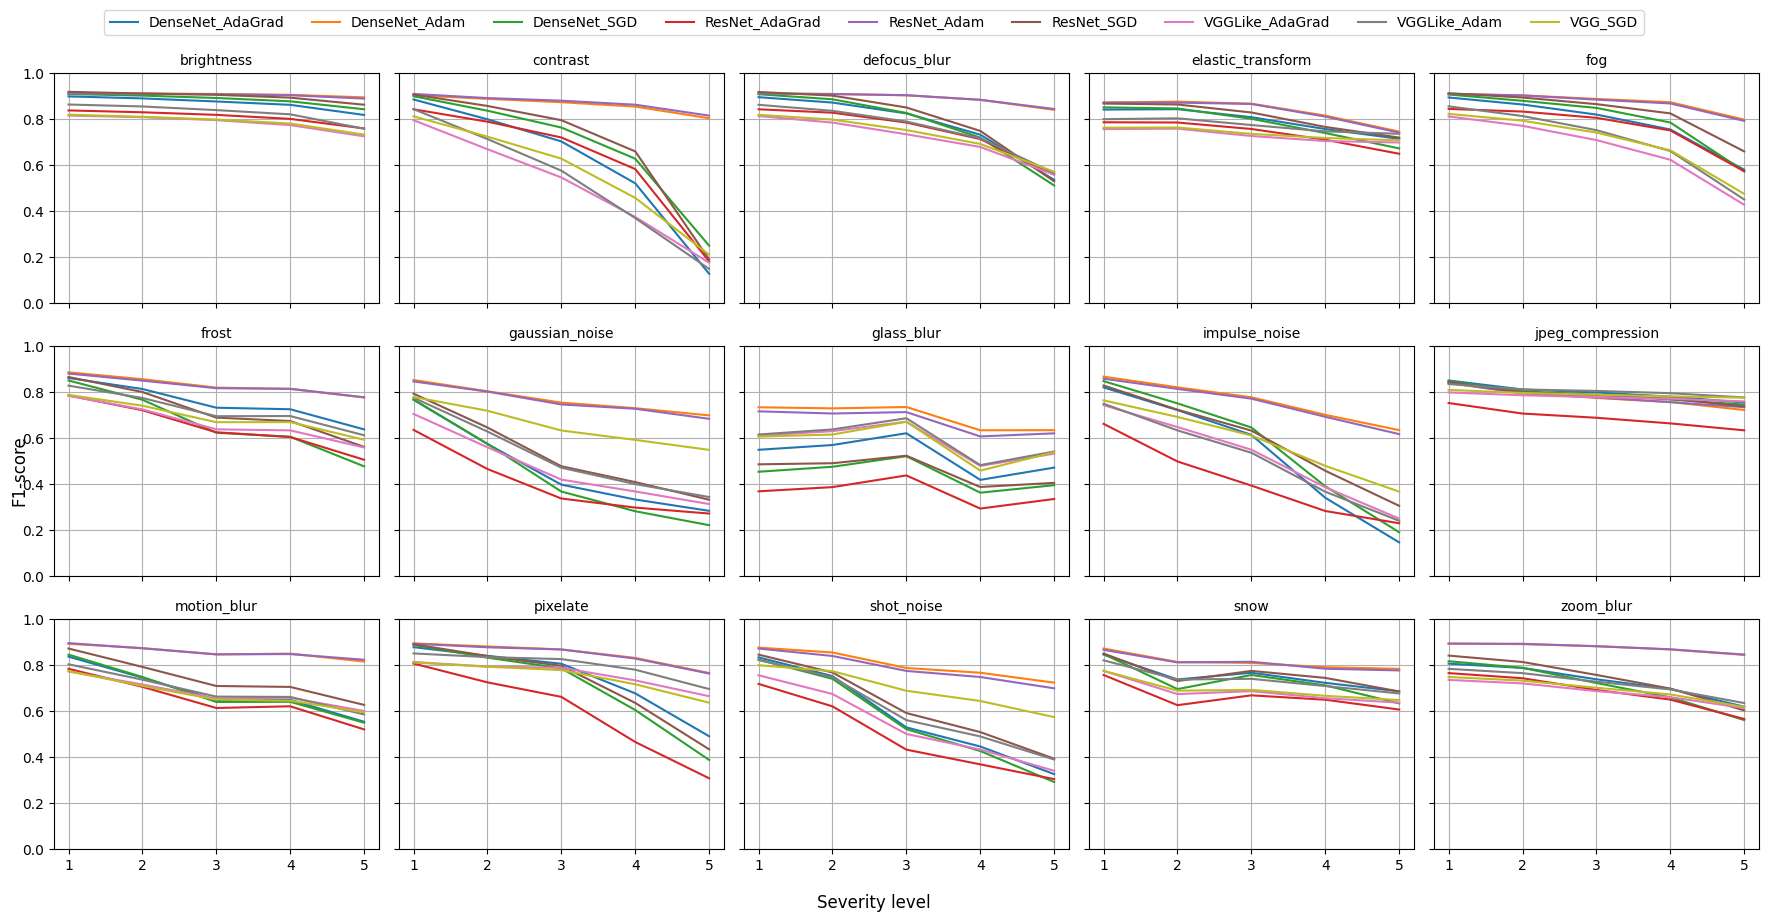

In [12]:
"""
Courbes de dégradation par corruption pour voir comment chaque modèle se dégrade avec la sévérité croissante d’une corruption donnée
    => montre quels modèles résistent le mieux à une corruption spécifique.

Axe X : Niveaux de sévérité (1 à 5)
Axe Y : Performance
"""


fig, axes = plt.subplots(3, 5, figsize=(18, 9), sharex=True, sharey=True)
axes = axes.flatten()

for c_idx, corruption in enumerate(corruption_list):
    ax = axes[c_idx]
    for m_idx, model_name in enumerate(model_names):
        ax.plot(
            range(1, 6),
            all_data[m_idx, c_idx],
            label=model_name,
            linewidth=1.5
        )
    ax.set_title(corruption, fontsize=10)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_ylim(0, 1)
    ax.grid(True)

fig.supxlabel('Severity level', fontsize=12)
fig.supylabel('F1-score', fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=n_models, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()